In [1]:
import os, time
import numpy as np 
from simbig import halos as Halos
from simbig import galaxies as Galaxies
from simbig import forwardmodel as FM

In [2]:
from simbig import obs as CosmoObs

In [3]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Read in `Quijote` Halo Catalog

In [4]:
# read in halo catalog
t0 = time.time()
halos = Halos.Quijote_LHC_HR(1, z=0.5)
print('halo readin takes %f sec' % ((time.time() - t0)))

halo readin takes 0.216496 sec


This halo catalog has the following cosmology

In [5]:
print('Om, Ob, h, ns, s8:')
print(Halos.Quijote_LHC_cosmo(1))

Om, Ob, h, ns, s8:
(0.21390000000000003, 0.055570000000000008, 0.85990000000000011, 0.97850000000000004, 0.86189999999999989)


# Populate halos with HOD
We'll use best-fit HOD parameters for LOWZ

In [6]:
# get LOWZ HOD parameters
theta_hod = Galaxies.thetahod_lowz_sgc()

Now apply HOD. This populates the halo catalog in a box with galaxies

In [7]:
# apply HOD
t0 = time.time()
hod = Galaxies.hodGalaxies(halos, theta_hod, seed=0)
print('HOD takes %f sec' % ((time.time() - t0)))

HOD takes 3.786370 sec


# calculate $P_\ell(k)$ for periodic box

In [8]:
# apply RSD to hod catalog in a box
pos_rsd = FM.Box_RSD(hod, LOS=[0,0,1], Lbox=1000)
hod_rsd = hod.copy()
hod_rsd['Position'] = pos_rsd

In [9]:
plk_box = CosmoObs.Plk_box(hod_rsd)

# Apply the forward model and calculate $P_\ell(k)$
Now lets apply the forward model with different levels of realism: 
1. only BOSS LOWZ South survey geometry
2. with veto mask
3. with fiber collisions

In [10]:
# apply forward model without veto mask, without fiber collisions
t0 = time.time()
gals = FM.BOSS(hod, sample='lowz-south', seed=0, veto=False, fiber_collision=False, silent=False)
print('forward model takes %f sec' % ((time.time() - t0)))

..applying angular mask takes 1 sec
..applying radial selection
..footprint covers 0.067 of sky
forward model takes 7.809501 sec


In [11]:
# get random
t0 = time.time()
rand = FM.BOSS_randoms(gals, sample='lowz-south', veto=False)
print('randoms take %f sec' % ((time.time() - t0)))

randoms take 0.622638 sec


In [13]:
t0 = time.time()
plk = CosmoObs.Plk_survey(gals, rand, Ngrid=360, dk=0.005, P0=1e4, silent=False)
print('plk take %f sec' % ((time.time() - t0)))

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


plk take 107.511951 sec


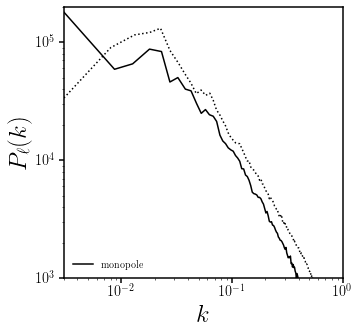

In [14]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.plot(plk_box[0], plk_box[1], c='k', ls=':')
sub.plot(plk[0], plk[1], c='k', label='monopole')
sub.legend(loc='lower left', fontsize=10)
sub.set_ylabel(r'$P_\ell(k)$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e3, 2e5)
sub.set_xlabel('$k$', fontsize=25)
sub.set_xlim([3e-3, 1.])
sub.set_xscale('log')

In [15]:
# apply forward model without veto mask, without fiber collisions
gals_veto = FM.BOSS(hod, sample='lowz-south', seed=0, veto=True, fiber_collision=False, silent=False)
rand_veto = FM.BOSS_randoms(gals, sample='lowz-south', veto=True)

plk_veto = CosmoObs.Plk_survey(gals_veto, rand_veto, Ngrid=360, dk=0.005, P0=1e4, silent=False)

..applying angular mask takes 1 sec
..applying veto takes 24 sec
..applying radial selection
..footprint covers 0.061 of sky


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


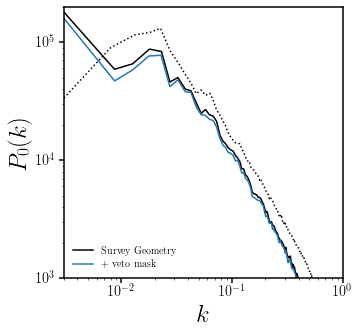

In [16]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.plot(plk_box[0], plk_box[1], c='k', ls=':')
sub.plot(plk[0], plk[1], c='k', label='Survey Geometry')
sub.plot(plk_veto[0], plk_veto[1], c='C0', label='+ veto mask')
sub.legend(loc='lower left', fontsize=10)
sub.set_ylabel(r'$P_0(k)$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e3, 2e5)
sub.set_xlabel('$k$', fontsize=25)
sub.set_xlim([3e-3, 1.])
sub.set_xscale('log')

In [17]:
# apply forward model with veto mask and fiber collisions
gals_veto_fc = FM.BOSS(hod, sample='lowz-south', seed=0, veto=True, fiber_collision=True, silent=False)

plk_veto_fc = CosmoObs.Plk_survey(gals_veto_fc, rand_veto, Ngrid=360, dk=0.005, P0=1e4, silent=False)

..applying angular mask takes 1 sec
..applying veto takes 25 sec
..applying radial selection
spherematch takes 9.910167 sec
..applying fiber collisions takes 10 sec
..footprint covers 0.061 of sky


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


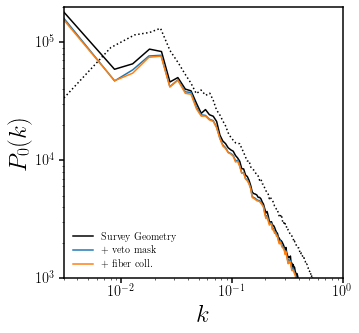

In [18]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.plot(plk_box[0], plk_box[1], c='k', ls=':')
sub.plot(plk[0], plk[1], c='k', label='Survey Geometry')
sub.plot(plk_veto[0], plk_veto[1], c='C0', label='+ veto mask')
sub.plot(plk_veto_fc[0], plk_veto_fc[1], c='C1', label='+ fiber coll.')
sub.legend(loc='lower left', fontsize=10)
sub.set_ylabel(r'$P_0(k)$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e3, 2e5)
sub.set_xlabel('$k$', fontsize=25)
sub.set_xlim([3e-3, 1.])
sub.set_xscale('log')